## Food webs generator 
In order to create a food web the most important thing to do is declaring two/three parameters: the number of nodes, the number of links and/or the connectance (meaning how many real links there should be with respect to the total number of possible links). <br>
The number of effective parameters then could be just S and C, nodes and connectance.  


In [2]:
import numpy as np

#### Be careful that the number of actual links must be less than $(S^2 - S )/2$ since it is not feasible that a predator eats a prey and the prey eats back the predator. It means that if a link appears in $A_{ij}$ it should not appear in $A_{ji}$. Eventually the total number of effective links should be at most half of the total possible connections (minus the diagonal terms that represent cannibalism)

##### Random matrices
In the random case, we construct the matrices in the following way: 
- For each coefficient $M_{i,j}$ we draw a random value $p$ from a uniform distribution $U[0, 1]$. 
- If the value is $p \le C$, we set coefficient $M_{i,j}=1$. 
- Otherwise ($p > C$), $M_{i,j} = 0$.

These matrices, for large $S$, generate a precise mixture of interaction types, with predator-prey interactions being represented twice as frequently as mutualistic or competitive ones (Table $S1$).

In [165]:
# the most generic adjacency matrix has SxS elements 

# random matrix should have C*S*S non zero elements. In order to generate a matrix that respects such requirements 
# we can draw a random number from a uniform distribution U([0,1]) and associate it to a matrix element, if that 
# number is lower than the connectance then we assign that coefficient to one otherwise it is set to zero

def generate_random(s,c):
    np.random.seed(1234)
    temp = np.zeros((s,s))
    p = np.random.uniform(0,1,s*s)
    mask = (p <= c).reshape(s,s)
    temp[mask] = 1
    rowsum = temp.sum(axis = 1)
    colsum = temp.sum(axis = 0)
    mask = (rowsum + colsum) == 0
    temp = temp[~mask][:,~mask]
    return temp.astype(int)

print("The number of effective links in the adjacency matrix is",generate_random(10,0.1).sum(), "wrt", 10*10, "total possible links")



The number of effective links in the adjacency matrix is 9 wrt 100 total possible links


In [262]:
h = generate_niche(100,0.1)
# h[~condition] where condition will be the fact that a column and a row are empty
# h[h.any(axis = 1)][:, h.any(axis = 0)].shape
row = np.all(h == 0, axis=1)
col = np.all(h == 0, axis=0)
# then i select those rows/columns that are not satisfying the zero elements condition
h[~row][:,~col].shape

# this would work only if we were looking for all columns and rows that are both equal to zero and deleting them. The problem is that, 
# as we see in this example, the number of rows and cols we end up with is different, the result is no more a square matrix and we 
# don't want behaviours like this. Indeed in this case we were deleting also those rows or columns that correspond to the same column or row 
# that is contemporary zero.

G = nx.from_numpy_matrix(h, create_using=nx.Graph)
G.remove_nodes_from(list(nx.isolates(G)))
nx.convert_matrix.to_numpy_array(G).shape

(100, 100)

In [318]:
h = generate_niche(100,0.1)
rowsum = h.sum(axis = 1)
colsum = h.sum(axis = 0)
mask = (rowsum + colsum) == 0
h[~mask][:,~mask].shape

(100, 100)

In [251]:
a = np.array([[0,0,0],[4,5,6]])
a.any(axis = 1)

array([False,  True])

##### Cascade model matrices
The cascade model assigns each species a random value drawn uniformly from the interval $[0,1]$ and each species has probability $P=2CS/(S-1)$ of consuming only species with values less than its own. This pecking order helps to explain species richness among trophic levels but understimates interspecific trophic similarity and overstimates food-chain length and number in larger webs.

In [3]:
# as we will see in the niche model we should assign to each specie a number drawn uniformly in 0,1 that sets the value of the niche of that 
# specie. Then we draw another number in 0,1 and compare it to the probability P, if the latter is smaller than P then we build links from 
# that specie to those ones that have a niche value smaller than its one.

m = np.zeros((3,3))
# n = np.random.uniform(0,1, size = 3)
p = 2*0.3*3/2

In [4]:
# in order to build the correct matrix we should sort from the lowest to the highest value of n the species we are considering 
# when sorting n we should also reorder the species associated to those n numbers, but we can realize that we can always sort the adjacency
# matrix rows in order to have the correct order of species with associated n

# now since we are sure that what we are going to populate is just an upper triangle matrix except for diagonal terms we may also do not draw
# the niche values and just apply a mask to that kind of matrix depending on the probability p of filling it with ones (links)

# n_sort = np.sort(n)

# let's fill columns with respect to that probability 

pc = np.random.uniform(0,1, size = 3)
m[:, pc < p] = 1
m_cascade = np.triu(m, k = 1)
m_cascade


array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [166]:
# let's generalize the process 

def generate_cascade(s,c):
    np.random.seed(1234)
    m = np.zeros((s,s))
    p = 2*c*s/(s-1)
    pc = np.random.uniform(0,1, size = s)
    m[:, pc < p] = 1
    m = np.triu(m, k = 1)
    rowsum = m.sum(axis = 1)
    colsum = m.sum(axis = 0)
    mask = (rowsum + colsum) == 0
    m = m[~mask][:,~mask]
    return m.astype('int') # since m is a binary matrix of zeros and ones it is sufficient to have int as type of the ndarray
    # in this way we select only those elements in the upper triangle matrix wrt m by also prohibiting self loops (k is greater than zero)

print("The number of effective links in the adjacency matrix is", generate_cascade(10,0.1).sum(), "wrt", 10*10, "total possible links")



The number of effective links in the adjacency matrix is 0 wrt 100 total possible links


##### Niche model matrices
The niche model similarly assigns each species a randomly drawn "niche value". The species are then constrained to consume all prey species within one range of values whose randomly chosen centre is less than the consumer's niche value. The single range adds a community-level contiguity of niche space to the cascade model by causing species with similar niche values to share consumers frequently within the community. The placement of the niche partially relaxes the cascade hierarchy by allowing up to half a consumer's range to include species with niche values higher than the consumer's value. 

Each of S species (for example, S = 6, each shown as an inverted triangle) is assigned a 'niche value' parameter ($\nu_i$) drawn uniformly from the interval [0,1]. Species i consumes all species falling in a range ($r_i$) that is placed by uniformly drawing the centre of the range ($c_i$) from [$r_i/2, \nu_i$]. This permits looping and cannibalism by allowing up to half of ri to include values > $\nu_i$. The size of $r_i$ is assigned by using a beta function to randomly draw values from [0,1] whose expected value is 2C and then multiplying that value by $\nu_i$ [expected $E(\nu_i)$ = 0.5] to obtain the desired C. A beta distribution with a = 1 has the form $f(x|1, \beta) = \beta(1-x)\beta^{-1}, 0 , x , 1, 0$ otherwise, and $E(X) = 1/(1+\beta)$. In this case, $x = 1 -(1-y)1/\beta$ is a random variable from the beta distribution if y is a uniform random variable and b is chosen to obtain the desired expected value. We chose this form because of its simplicity and ease of calculation. The fundamental generality of species i is measured by $r_i$. The number of species falling within ri measures realized generality. Occasionally, model-generated webs contain completely disconnected species or trophically identical species. Such species are eliminated and replaced until the web is free of such species. The species with the smallest $\nu_i$ has $r_i = 0$ so that every web has at least one basal species.

In [3]:
# let's first assign a niche value to each species 

niche_species = dict()
for i in range(5):
    niche_species[i+1] = np.random.uniform(0, 1)

# now we have for n species a niche value and an id number representing them 
# in order to manipulate easily those n species we could create a pandas dataframe from a numpy array that has as indices the id of the specie
import pandas as pd

dataframe = pd.DataFrame(np.zeros((5,5)))#, index = np.arange(5) + 1) 
dataframe.columns = np.arange(5) + 1
dataframe.set_index(dataframe.columns)

# we then substitute columns names and indices with niche values np.random.uniform(0, 1)
ni = np.random.uniform(0, 1, size = 5)

dataframe = dataframe.set_index(ni)
dataframe.columns = ni

# species i consumes all species falling in a range ri that is placed by uniformly drawing the centre of the range ci from [ri/2,ni]
# ri is assigned randomly using a beta function whose expected value is two times the connectance C and then multiplying that value by ni
# in order to have an expected value of C for the radius of each species niche

If we want to use a beta distribution whose expected value is $2C$ then we are obliged to set:

$$
E(X) = \frac{1}{1+\beta} \Rightarrow 2C = \frac{1}{1+\beta} \Rightarrow \beta = \frac{1}{2C} - 1
$$

and of course $\alpha=1$

In [7]:
y = np.random.uniform(0, 1, size = 5)
ri = ni*(1 - (1 - y)**(2*0.1/(1-2*0.1)))
ci = np.random.uniform(ri/2, ni)
lower_bound = ci - ri/2
upper_bound = ci + ri/2
# lower and upper bounds are one for each column so when we do comparisons we should consider them one at time 

# sanity check
if np.all(lower_bound < upper_bound) : print("radii have been correctly created")

radii have been correctly created


In [8]:
# now we have to filter rows elements for each column in the dataframe and fill those that satisfy the condition with ones

a = dataframe[dataframe.columns[4]].index > lower_bound[4] 

In [9]:
b = dataframe[dataframe.columns[0]].index < upper_bound[0]

In [10]:
dataframe[dataframe.columns[0]][a*b] = 1

In [11]:
# now let's vectorize it all 
# or operation with multiplication of boolean arrays 

dataframe[((dataframe.index.T > lower_bound[:,None]).T)*((dataframe.index.T < upper_bound[:,None]).T)] = 1


what is going on? Why are we comparing dataframe columns like this?

`dataframe.index` is a pandas series of shape (5,) while `lower_bound` is a np.array of the same dimension. If we want to compare each element 
of the first array with one single element of `lower_bound` we could write `dataframe.index` `>` `lower_bound[0]` and iterate over components of 
`lower_bound` but it would be computationally demanding if the number of species is large since we would be doing this comparison sequentially.

It is better to make this comparison in a vectorial form but how?
Normally a np.array is a row vector containing as many elements as the array dimension. For this reason if we compare this array with a column vector, by adding a newaxis to the other vector, we could end up with a matrix where each row is the elementwise comparison between the first row vector and the first row of the other one, that is actually a scalar. We would see at the end a shapeXshape matrix with each row the elementwise comparison between the row vector and the correspondent row (scalar) of the newaxis-ed vector. In order to have the matrix we would like to end up with we should transpose the result as we want each column containing links satisfying the niche eating condition.

In [167]:
def generate_niche(s,c):
    np.random.seed(1234)
    dataframe = pd.DataFrame(np.zeros((s,s))) 
    dataframe.columns = np.arange(s) + 1
    dataframe.set_index(dataframe.columns)

    # we then substitute columns names and indices with niche values np.random.uniform(0, 1)
    ni = np.random.uniform(0, 1, size = s)

    dataframe = dataframe.set_index(ni)
    dataframe.columns = ni
    y = np.random.uniform(0, 1, size = s)
    ri = ni*(1 - (1 - y)**(2*c/(1-2*c)))
    ci = np.random.uniform(ri/2, ni)
    lower_bound = ci - ri/2
    upper_bound = ci + ri/2
    dataframe[((dataframe.index > lower_bound[:,None]).T)*((dataframe.index < upper_bound[:,None]).T)] = 1
    n = np.array(dataframe)
    rowsum = n.sum(axis = 1)
    colsum = n.sum(axis = 0)
    mask = (rowsum + colsum) == 0
    n = n[~mask][:,~mask]
    return n.astype('int')

print("The number of effective links in the adjacency matrix is", generate_niche(10,0.1).sum(), "wrt", 10*10, "total possible links")


The number of effective links in the adjacency matrix is 10 wrt 100 total possible links


In [13]:
generate_niche(10,0.4) # in order to visualize it 

array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 1, 1]])

##### Nested hierarchy model 
This modeling framework gives each species a niche value and a range, exactly as in the Niche Model. However, instead of establishing links directly to species within the range, first the number of prey to be consumed by each species is determined, in proportion to the range, $k_{in}^i \propto r_i$ , so as to generate an expected number of links L, if the resulting number exceeded S-1, we arbitrarily reduced it to S-1. These links are then attributed in the following way. The species with lowest niche value has no prey, while the one with the highest has no predators (so there is always at least one basal species and one apex  redator). Starting from the species with second smallest niche value and going up in order of n, we take each species i and apply the following rules to determine its $k_{in}^i$ prey:
1. We choose a random species j already in the network (so $n_j \le n_i$) and set it as the first prey species of i.
2. If j has no predators other than i, we repeat 1 until either the chosen prey does have other predators, or we reach $k_{in}^i$. Else we go to 3.
3. We determine the set of species which are prey to the predators of j. We select, randomly, species from this set to become also prey of i until we either complete $k_{in}^i$, or we go to 4.
4. We continue choosing prey species randomly from among those with lower niche values. If we still have not reached $k_{in}^i$ when these run out, we continue choosing them randomly from those with higher niche values.

By creating groups of consumers, stage one (2) expresses the part in food-web organization that is determined by phylogenetic constraints. Links attributed to species free of consumers, and links distributed randomly in the second stage, render the adaptation of consumers to new prey. In forcing consumers to form various trophic groups, our ‘nested-hierarchy model’ escapes the one dimensional nature of former models, and better reflects the kind of hierarchies emanating from the phylogenetic structure of the community.

In [1]:
import numpy as np
import pandas as pd

In [137]:
s = 10
c = 0.3
dataframe = pd.DataFrame(np.zeros((s,s)))#, index = np.arange(5) + 1) 
# dataframe.columns = np.arange(s) + 1
# dataframe.set_index(dataframe.columns)

# we then substitute columns names and indices with niche values np.random.uniform(0, 1)
ni = np.random.uniform(0, 1, size = s)

dataframe = dataframe.set_index(ni)
dataframe.columns = ni
# we could now just reorder the dataframe for ascending values of ni 
dataframe.columns = dataframe.columns.sort_values() 
dataframe = dataframe.set_index(dataframe.columns)
y = np.random.uniform(0, 1, size = s)
ri = ni*(1 - (1 - y)**(2*c/(1-2*c)))
ri /= np.sum(ri)
ri = (ri*s*s*c).astype(int)
ri[0] = 0
ri[ri > s-1] = s-1
# devo capire come togliere questa correzione per ri 
# r = np.arange(s) + 1
# ri = [r[i] if ri[i] > r[i] else ri[i] for i in range(s)]
# dataframe.sum(axis = 0) # sum id done row wise meaning we end up with the sum of all columns each one with its index 

In [138]:
# third try of implementation 

for i in range(s):
    while dataframe[dataframe.columns[i]].sum() < ri[i]:
        print(i)
        randomprey = np.random.randint(i+1) # 1
        dataframe[dataframe.columns[i]].iloc[randomprey] = 1
        if dataframe.iloc[randomprey].sum() == 1: # 2 
            # randomprey0 = np.random.randint(i+1)
            # dataframe[dataframe.columns[i]].iloc[randomprey0] = 1
            print("pino")
        elif dataframe[dataframe.columns[i]].sum() < ri[i]: 
            try: 
                # !!!!!!!! randomprey1 = np.random.choice(dataframe[dataframe.columns[randomprey]][dataframe[dataframe.columns[randomprey]] != 0].index)
                a = np.random.choice(dataframe[dataframe.columns[dataframe.iloc[randomprey] != 0]].columns)
                randomprey1 = np.random.choice(dataframe[dataframe[a] != 0].index)
                print("random prey uno è",randomprey1)
                # dataframe[dataframe.columns[i]].iloc[randomprey] = 1
                dataframe[dataframe.columns[i]].loc[randomprey1] = 1
            except: print("eccezione")

        if (dataframe[dataframe.columns[i]].sum() < ri[i]) and (dataframe.iloc[randomprey].sum() == 1):
            randomprey0 = np.random.randint(i,s)
            dataframe[dataframe.columns[i]].iloc[randomprey0] = 1
            print("pino ino")
        elif (dataframe[dataframe.columns[i]].sum() < ri[i]) and (dataframe.iloc[randomprey].sum() != 1):
            randomprey2 = np.random.randint(i,s) 
            print("random prey due è",randomprey2)
            dataframe[dataframe.columns[i]].iloc[randomprey2] = 1
            # else: continue


2
pino
pino ino
3
pino
pino ino
5
pino
7
random prey uno è 0.3324840096442452
random prey due è 9
7
random prey uno è 0.011806077797101966
random prey due è 9
7
random prey uno è 0.17677894959329388
random prey due è 9
7
pino
pino ino
7
pino
pino ino
8
random prey uno è 0.3324840096442452
random prey due è 8
8
random prey uno è 0.011806077797101966
random prey due è 9
8
pino
9
random prey uno è 0.011806077797101966
random prey due è 9
9
random prey uno è 0.3324840096442452
random prey due è 9
9
random prey uno è 0.8655985052909494
random prey due è 9
9
random prey uno è 0.3324840096442452
random prey due è 9
9
random prey uno è 0.011806077797101966
random prey due è 9
9
pino
pino ino
9
random prey uno è 0.011806077797101966
random prey due è 9
9
pino
pino ino
9
random prey uno è 0.3324840096442452
random prey due è 9
9


In [139]:
dataframe.sum().sum() == sum(ri)

True

In [140]:
sum(ri)

25

In [131]:
dataframe

,0.084842,0.320548,0.346153,0.347648,0.503987,0.728150,0.782175,0.788539,0.798590,0.893067
0.084842,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
0.320548,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
0.346153,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
0.347648,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0.503987,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0.728150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.782175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0.788539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0.798590,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0.893067,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [9]:
# second try of implementation 

for i in range(s):
    while dataframe[dataframe.columns[i]].sum() < ri[i]:
        randomprey = np.random.randint(i+1) # 1
        if dataframe.iloc[randomprey].sum() == 1: # 2 
            dataframe[dataframe.columns[i]].iloc[randomprey] = 1
        # perchè deve farlo fino a quando non riempie eventualmente tutti gli elementi della seconda colonna che non hanno ancora nessun predatore.
        else: # deve comprendere il punto precedente # 3
            # randomprey1 = np.random.randint(dataframe[dataframe.columns[randomprey]]+1)
            dataframe[dataframe.columns[i]].iloc[randomprey] = 1
            try: 
                # !!!!!!!! randomprey1 = np.random.choice(dataframe[dataframe.columns[randomprey]][dataframe[dataframe.columns[randomprey]] != 0].index)
                a = np.random.choice(dataframe[dataframe.columns[dataframe.iloc[randomprey] != 0]].columns)
                randomprey1 = np.random.choice(dataframe[dataframe[a] != 0].index)
                dataframe[dataframe.columns[i]].loc[randomprey1] = 1
            except: continue
            if (dataframe[dataframe.columns[i]].sum() < ri[i]): #and (dataframe.iloc[randomprey].sum() != 1):
                randomprey2 = np.random.randint(i,s) 
                dataframe[dataframe.columns[i]].iloc[randomprey2] = 1
            else: continue
dataframe
# dataframe.iloc[s-1][dataframe.columns[:-1]] = np.zeros(s-1)  

,0.113929,0.960883
0.113929,0.0,0.0
0.960883,0.0,1.0


In [743]:
# devo fare due random choice. il primo, più interno sulle colonne che sono i predatori di j prima che pongo l'elemento uguale a uno,
# il secondo invece sulle righe che sono il gruppo di prede del predatore scelto prima. Se non ci sono prede ricomincio il ciclo di ricerca 
# di un predatore con prede diverse da j (tanto ancora non l'ho messo uguale a uno)

# dataframe[dataframe.columns[randomprey]][dataframe[dataframe.columns[randomprey]] != 0].index
a = np.random.choice(dataframe[dataframe.columns[dataframe.iloc[randomprey] != 0]].columns) # questo sceglie la colonna che sarebbe il predatore
# da dentro la colonna poi devo scegliere tra quelle possibili righe che sono diverse da zero e ne prendo l'indice 
b = np.random.choice(dataframe[dataframe[a] != 0].index)
# dataframe[dataframe.columns[randomprey]].iloc[1] = 1

Float64Index([0.057066554394480495, 0.17474177534561308], dtype='float64')

In [41]:
dataframe.sum().sum() == sum(ri)

False

In [496]:
# for each column now we have to set a loop that assigns as many links as there are depicted into ri vector 
# first try of implementation 

for i in range(s):
    while dataframe[dataframe.columns[i]].sum() < ri[i]:
        randomprey = np.random.randint(i+1)
        dataframe[dataframe.columns[i]].iloc[randomprey] = 1
        if (dataframe.iloc[i].sum() != 1) and (dataframe[dataframe.columns[i]].sum() < ri[i]):
            randomprey1 = np.random.randint(dataframe[dataframe.columns[randomprey]]+1)
            dataframe[dataframe.columns[i]].iloc[randomprey1] = 1
        else: continue
    randomprey2 = np.random.randint(i,s) # 4
    dataframe[dataframe.columns[i]].iloc[randomprey2] = 1
dataframe.iloc[s-1][dataframe.columns[:-1]] = np.zeros(s-1)
dataframe[dataframe.columns[0]] = np.zeros(s)

In [498]:
# ora il problema sta nel fatto che a volte ci sono più link di quelli che mi aspetterei dentro certe colonne. succede quando si arriva al 
# punto 4 ma già il numero di elementi nella colonna è stato raggiunto. Adesso invece oltre quello alcune colonne non si completano 
dataframe

,0.078309,0.173838,0.295976,0.306453,0.404581,0.489113,0.716330,0.786893,0.843647,0.880366
0.078309,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
0.173838,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
0.295976,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
0.306453,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0.404581,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
0.489113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.716330,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
0.786893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.843647,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0.880366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [180]:
def generate_nested(s,c, check = False):
    np.random.seed(1234)
    dataframe = pd.DataFrame(np.zeros((s,s)))#, index = np.arange(5) + 1) 
    ni = np.random.uniform(0, 1, size = s)
    dataframe = dataframe.set_index(ni)
    dataframe.columns = ni
    dataframe.columns = dataframe.columns.sort_values() 
    dataframe = dataframe.set_index(dataframe.columns)
    y = np.random.uniform(0, 1, size = s)
    ri = ni*(1 - (1 - y)**(2*c/(1-2*c)))
    ri /= np.sum(ri)
    ri = (ri*s*s*c).astype(int)
    ri[0] = 0 # in order to have at least a basal species
    ri[ri > s-1] = s-1
    for i in range(s):
        while dataframe[dataframe.columns[i]].sum() < ri[i]:
            randomprey = np.random.randint(i+1) # 1
            dataframe[dataframe.columns[i]].iloc[randomprey] = 1
            if dataframe.iloc[randomprey].sum() == 1: # 2 
                True
            elif dataframe[dataframe.columns[i]].sum() < ri[i]: 
                try: 
                    a = np.random.choice(dataframe[dataframe.columns[dataframe.iloc[randomprey] != 0]].columns)
                    randomprey1 = np.random.choice(dataframe[dataframe[a] != 0].index)
                    dataframe[dataframe.columns[i]].loc[randomprey1] = 1
                except: continue
            if (dataframe[dataframe.columns[i]].sum() < ri[i]) and (dataframe.iloc[randomprey].sum() == 1):
                randomprey0 = np.random.randint(i,s)
                dataframe[dataframe.columns[i]].iloc[randomprey0] = 1
            elif (dataframe[dataframe.columns[i]].sum() < ri[i]) and (dataframe.iloc[randomprey].sum() != 1):
                randomprey2 = np.random.randint(i,s) 
                dataframe[dataframe.columns[i]].iloc[randomprey2] = 1
    if (dataframe.sum().sum() == sum(ri)) and check == True: print("sanity check")
    dataframe.iloc[s-1][dataframe.columns[:-1]] = np.zeros(s-1) # in order to have at least a top species
    n = np.array(dataframe)
    return n.astype(int)

print("The number of effective links in the adjacency matrix is", generate_nested(10,0.3, check = True).sum(), "wrt", 10*10, "total possible links")


sanity check
The number of effective links in the adjacency matrix is 24 wrt 100 total possible links


In [193]:
generate_nested(10,0.3, check = True)

sanity check


array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

#### Trying to represent the foodwebs with networkX

['A', 'B', 'C', 'D', 'E']
[('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'E'), ('C', 'E')]


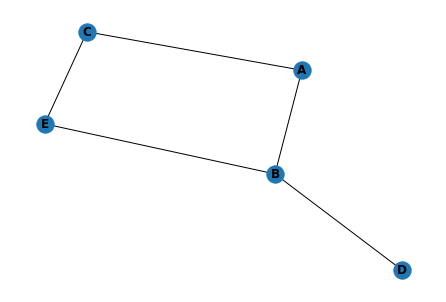

2

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
# to access the nodes and the links of the graph we can use these commands. Both return a list in python vanilla 

# print(G.nodes()) # returns a list
# print(G.edges()) # returns a list

# Suppose, we want to add a vertex (also called a node) in G.  We can add a node in G as follows:
G.add_node('A')

# The above command will add a single node A in the graph G. If we want to add multiple nodes at once, then we can use the following command:
G.add_nodes_from(['B','C','D','E'])
# These are just isolated vertices because we have not added any edges to the graph G.

# We can add an edge connecting two nodes A and B as follows:
G.add_edge(*('A','B'))
# or multiple ones like this 
G.add_edges_from([('A','C'), ('B','D'), ('B','E'), ('C', 'E')])
print(G.nodes()) 
print(G.edges()) 

# in order to draw a graph we can write 
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

# if we want to see the degree of a node we can simply write 
G.degree('A')

Creating weighted graph

Now, we will learn how to create a weighted graph using ‘networkx’ module in Python. Here, a weighted graph represents a graph with weighted edges. In general, we consider the edge weights as non-negative numbers.
In the following example, E is a Python list, which contains five elements. Each of these elements is a Python tuple having three elements. The first two elements denote the two endpoints of an edge and the third element represents the weight of that edge. Finally, we need to add these weighted edges to G.

`G = nx.Graph()` <br> 
`E = [(‘A’, ‘B’, 2), (‘A’, ‘C’, 1), (‘B’, ‘D’, 5), (‘B’, ‘E’, 3), (‘C’, ‘E’, 2)]` <br>
`G.add_weighted_edges_from(E)` <br>

We have already seen above how to draw an unweighted graph. Now, we will learn how to draw a weighted graph using ‘networkx’ module in Python. The complete code is mentioned below:

`pos=nx.spring_layout(G)` <br>
`nx.draw(G, pos, with_labels=True, font_weight=’bold’)` <br>
`edge_weight = nx.get_edge_attributes(G,’weight’)` <br>
`nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)` <br>
`plt.show()`

In [15]:
import FoodWebAnalysis as fw
import matplotlib as mpl


In [16]:
def create_fixed_positions(A,          # adj matrix
                           ybasal,     # y coordinate of all basal species, will be given in the successive function that draws the graph
                           ytop,       # y coordinate of all top species, ""
                           spacing     # x distance between two near basal or top species
                           ):
    
    
    basal = fw.basal_species(A)
    top = fw.top_species(A)
    
    fixed_positions = {}
    n = 0
    m = 0
    
    for i in range(len(top)):
        
        if(basal[i]==1):
            # n=0 x=0, n=1 x=-1, n=2 x=1, n=3 x=-2, ... 
            x = int((n+1)/2)*(-1)**n
            fixed_positions[i] = (x*spacing,ybasal)    
            n += 1
            
        if(top[i]==1):
            x = int((m+1)/2)*(-1)**m
            fixed_positions[i] = (x*spacing,ytop)    
            m = m+1
 
    return fixed_positions
    # fixed positions returns just the positions of the basal and top species that will have a constant horizontal spacing while a fixed 
    # vertical position 

In [17]:
def dir_graph(A,                                     # adj matrix
              node_colors,                           # vector of scores, one for each node
              node_size, 
              width,
              seed = 4020,                           # thanks to initial constraints seed should not be relevant
              correction = True,
              modified_heights = "influence",
              ybasal=-1, ytop=1, spacing=0.1,        # parameters of position of fixed nodes
              edge_color='gray', cmap=plt.cm.copper, # colormap parameters
              colormap_label=""                      # colormap parameters
              ):         
    
    ###### Spring simulation ######
 
    # we simulate A as an "undirected" spring system, otherwise every node is rejected
    # by input edges, which is not good.
    G = nx.from_numpy_matrix(A, create_using=nx.Graph)
    # fixing position of top and basal nodes to impose structure
    fixed_positions = create_fixed_positions(A,ybasal,ytop,spacing)
    fixed_nodes = fixed_positions.keys()

    # dynamic simulation in order to distribute nodes in space by following the idea of spring connections: more links connect one species to 
    # another the stronger the hookes constant of the spring that connects the above mentioned two. Eventually more linked species will end 
    # up closer together whil less connected species will be placed farther from the rest.

    if(len(fixed_nodes)): 
        # if there are any basal or top species the algorithm consider the fixed positions as the ones of top and basals otherwise it run the 
        # simulation without specifying them 
        
        pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes, seed=seed)    
    else: 
        pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=(8, 6))
    
    # this is needed to have arrows
    G_dir = nx.from_numpy_matrix(A.T, create_using=nx.DiGraph)
    
    
    # Now we have our graph with basal species on the bottom layer and top in the top layer
    # but there is a problem. Because of the spring dynamic, semi-top predator which hunts a lot
    # of basal species are veery close to basal layer!
    #
    # In order to correct this we can fix the x position of the nodes, and set the y coordinate
    # equal for example to the trophic level squared!
    # instead of trophic level i'm using the pagerank that is proportional to the first 

    if(correction):
        
        if (modified_heights == "trophic2"):
            new_heights = fw.compute_trophic_levels(A,eps)**2
            
        elif (modified_heights == "influence"):
            new_heights = fw.all_influence_scores(A)
        
        elif (modified_heights == "hubs_pagerank"):
            A = A.T 
            # normalizing A columns to sum 1
            sums = A.sum(axis = 0) + 2**(-32)    
            M = A/sums                           
            new_heights = fw.PageRank(M,c=0.7)
            
        else:
            print("Error, unknown height correction used!")
            return 0
            
        #new_heights = fw.PageRank(A.T)
        
        for i in range(len(pos)):
            new_pos = pos[i]
            new_pos[1] = new_heights[i]
            
            pos[i] = new_pos
    
    
    ####### GRAPH #######
    
    fig1, ax1 = plt.subplots(figsize=(10, 10))
    nx.draw(G_dir, pos, node_color = node_colors, width=width, 
            node_size=node_size, edge_color=edge_color, cmap=cmap, ax=ax1)
    
    ax1.set_axis_on()
    ax1.tick_params(left=True,labelleft=True,which='major', labelsize=15)
    if(correction):
        ax1.set_ylabel("Trophic level squared",fontsize=20)
    
    ####### Colorbar ####### 
    
    fig2, ax2 = plt.subplots(figsize=(11, 0.5))
    fig2.subplots_adjust(bottom=0.5)
    
    norm=plt.Normalize(vmin = np.min(node_colors), vmax=np.max(node_colors))
    cbar = fig2.colorbar( mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                         cax=ax2, orientation = 'horizontal') #extend='max', orientation='horizontal')
    
    cbar.set_label(colormap_label, size=20)
    
    plt.show()
    return

<Figure size 576x432 with 0 Axes>

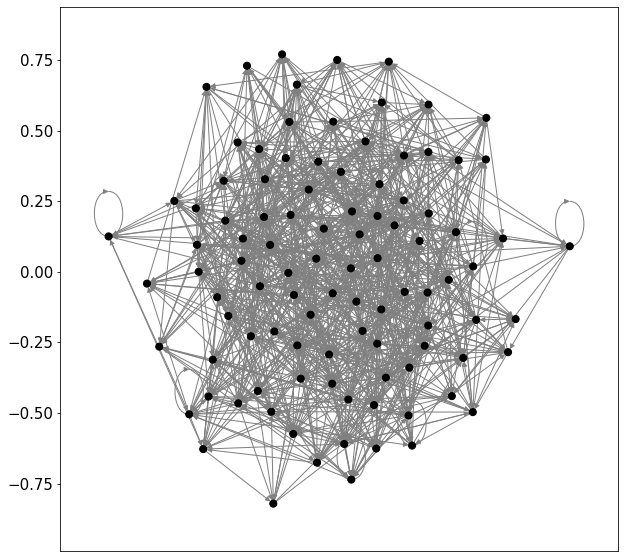

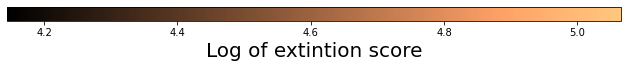

In [18]:
A = generate_random(100,0.1)
E = fw.all_extintion_scores(A)
node_colors = np.log(np.array(E))

dir_graph(A,node_colors,node_size=50,width=1,colormap_label='Log of extintion score',spacing=0.5, correction=False)

<Figure size 576x432 with 0 Axes>

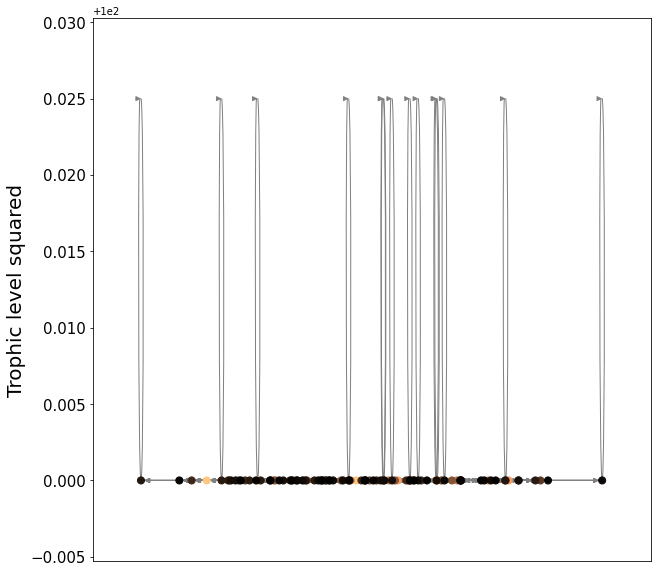

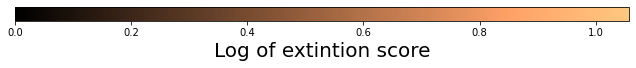

In [19]:
B = generate_cascade(100,0.1)
E = fw.all_extintion_scores(B)
node_colors = np.log(np.array(E))

dir_graph(A,node_colors,node_size=50,width=1,colormap_label='Log of extintion score',spacing=0.5, correction=True)

<Figure size 576x432 with 0 Axes>

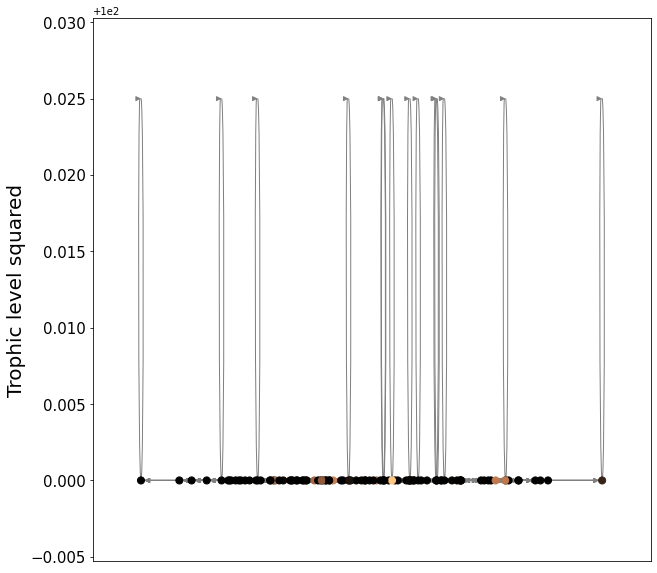

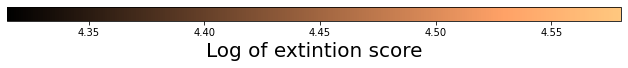

In [20]:
B = generate_niche(100,0.4)
E = fw.all_extintion_scores(B)
node_colors = np.log(np.array(E))

dir_graph(A,node_colors,node_size=50,width=1,colormap_label='Log of extintion score',spacing=0.5, correction=True)